In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

sns.set()
pd.set_option('display.max_columns', None)

In [32]:
# Load the csv dataset into pandas dataframes
data_file = os.path.join(os.getcwd(), 'dataset', 'hr_employee_attrition.csv')
hr_df = pd.read_csv(data_file)

All rows have values for each column. Therefore, there's no need to drop any rows.

In [33]:
hr_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [34]:
hr_df.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470,1470,1470.000000,1470,1470.000000,1470.000000,1470,1470.0,1470.000000,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470,1470.000000,1470.000000,1470.000000,1470,1470,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,2,3,NaN,3,NaN,NaN,6,NaN,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,NaN,Male,NaN,NaN,NaN,Sales Executive,NaN,Married,NaN,NaN,NaN,Y,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1233,1043,NaN,961,NaN,NaN,606,NaN,NaN,NaN,882,NaN,NaN,NaN,326,NaN,673,NaN,NaN,NaN,1470,1054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,802.485714,NaN,9.192517,2.912925,NaN,1.0,1024.865306,2.721769,NaN,65.891156,2.729932,2.063946,NaN,2.728571,NaN,6502.931293,14313.103401,2.693197,NaN,NaN,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,NaN,NaN,403.509100,NaN,8.106864,1.024165,NaN,0.0,602.024335,1.093082,NaN,20.329428,0.711561,1.106940,NaN,1.102846,NaN,4707.956783,7117.786044,2.498009,NaN,NaN,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,NaN,NaN,102.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,1.000000,NaN,30.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2094.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,NaN,NaN,465.000000,NaN,2.000000,2.000000,NaN,1.0,491.250000,2.000000,NaN,48.000000,2.000000,1.000000,NaN,2.000000,NaN,2911.000000,8047.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,NaN,NaN,802.000000,NaN,7.000000,3.000000,NaN,1.0,1020.500000,3.000000,NaN,66.000000,3.000000,2.000000,NaN,3.000000,NaN,4919.000000,14235.500000,2.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,NaN,NaN,1157.000000,NaN,14.000000,4.000000,NaN,1.0,1555.750000,4.000000,NaN,83.750000,3.000000,3.000000,NaN,4.000000,NaN,8379.000000,20461.500000,4.000000,NaN,NaN,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


# Exploring the Data

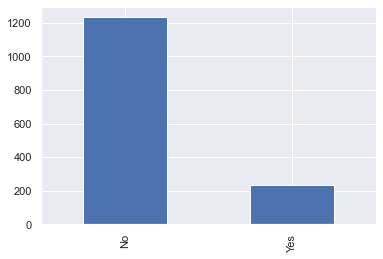

In [9]:
ax = hr_df['Attrition'].value_counts().plot(kind='bar');

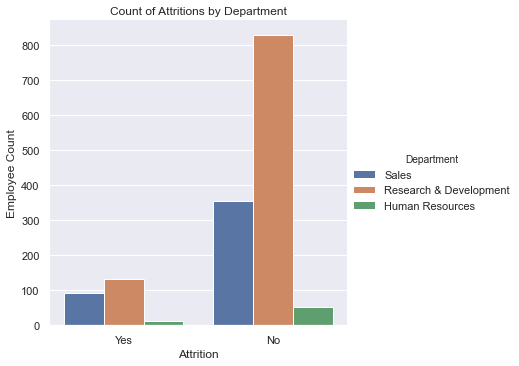

In [10]:
fig = sns.catplot(x='Attrition', kind='count', hue='Department' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Department");

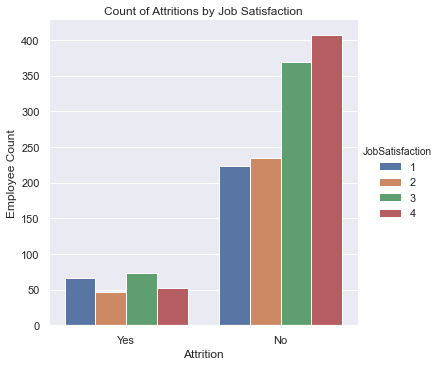

In [15]:
fig = sns.catplot(x='Attrition', kind='count', hue='JobSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Job Satisfaction");

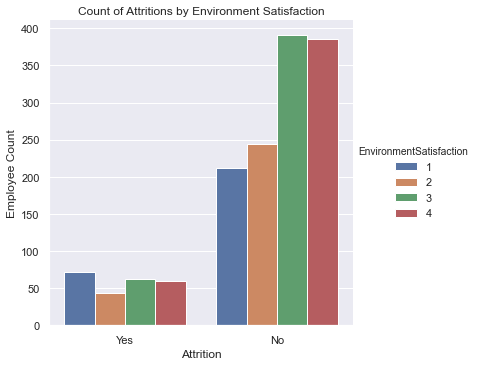

In [16]:
fig = sns.catplot(x='Attrition', kind='count', hue='EnvironmentSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Environment Satisfaction");

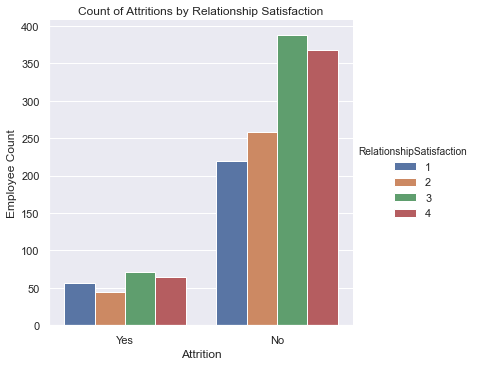

In [17]:
fig = sns.catplot(x='Attrition', kind='count', hue='RelationshipSatisfaction' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Relationship Satisfaction");

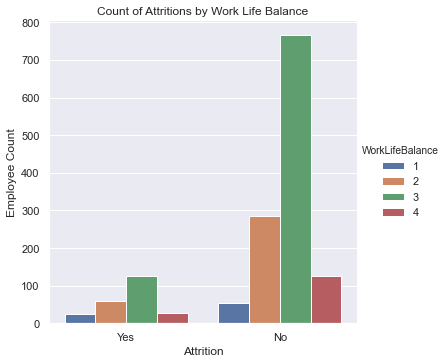

In [18]:
fig = sns.catplot(x='Attrition', kind='count', hue='WorkLifeBalance' ,data=hr_df )
fig.set(xlabel='Attrition', ylabel="Employee Count", title="Count of Attritions by Work Life Balance");

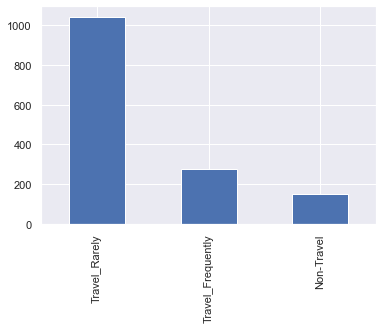

In [19]:
hr_df['BusinessTravel'].value_counts().plot(kind='bar')

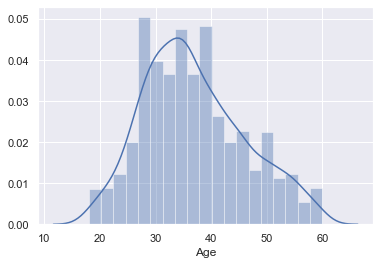

In [20]:
sns.distplot(hr_df['Age'])

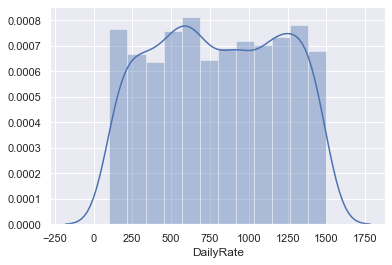

In [21]:
sns.distplot(hr_df['DailyRate'])

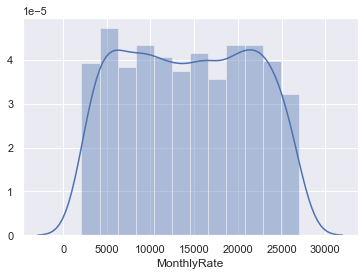

In [22]:
sns.distplot(hr_df['MonthlyRate'])

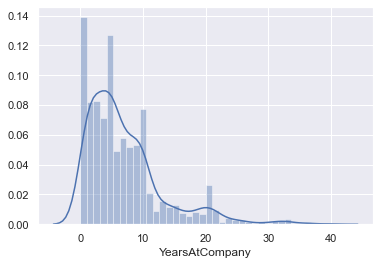

In [23]:
sns.distplot(hr_df['YearsAtCompany'])

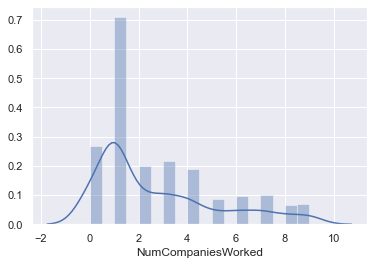

In [24]:
sns.distplot(hr_df['NumCompaniesWorked'])

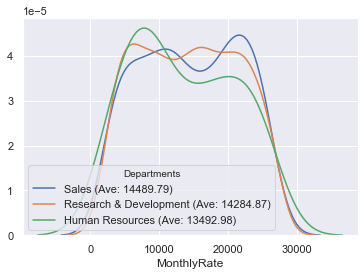

In [49]:
unique_depts = hr_df['Department'].unique()

for dept in unique_depts:
    subset = hr_df[hr_df['Department'] == dept]
    dept_mean = subset['MonthlyRate'].mean()
    dept_label = '{} (Ave: {:.2f})'.format(dept, dept_mean)
    sns.distplot(subset['MonthlyRate'], hist=False, label=dept_label)

plt.legend(title='Departments');

# EDA for those who were Attrited

In [52]:
leaver_df = hr_df[hr_df['Attrition'] == 'Yes']

In [53]:
leaver_df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0


In [54]:
leaver_df.describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,237.000000,237,237,237.000000,237,237.000000,237.000000,237,237.0,237.000000,237.000000,237,237.000000,237.000000,237.000000,237,237.000000,237,237.000000,237.000000,237.000000,237,237,237.000000,237.000000,237.000000,237.0,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000,237.000000
unique,NaN,1,3,NaN,3,NaN,NaN,6,NaN,NaN,NaN,2,NaN,NaN,NaN,9,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Yes,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,NaN,Male,NaN,NaN,NaN,Laboratory Technician,NaN,Single,NaN,NaN,NaN,Y,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,237,156,NaN,133,NaN,NaN,89,NaN,NaN,NaN,150,NaN,NaN,NaN,62,NaN,120,NaN,NaN,NaN,237,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,33.607595,NaN,NaN,750.362869,NaN,10.632911,2.839662,NaN,1.0,1010.345992,2.464135,NaN,65.573840,2.518987,1.637131,NaN,2.468354,NaN,4787.092827,14559.308017,2.940928,NaN,NaN,15.097046,3.156118,2.599156,80.0,0.527426,8.244726,2.624473,2.658228,5.130802,2.902954,1.945148,2.852321
std,9.689350,NaN,NaN,401.899519,NaN,8.452525,1.008244,NaN,0.0,580.750572,1.169791,NaN,20.099958,0.773405,0.940594,NaN,1.118058,NaN,3640.210367,7208.153264,2.678519,NaN,NaN,3.770294,0.363735,1.125437,0.0,0.856361,7.169204,1.254784,0.816453,5.949984,3.174827,3.153077,3.143349
min,18.000000,NaN,NaN,103.000000,NaN,1.000000,1.000000,NaN,1.0,1.000000,1.000000,NaN,31.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2326.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,NaN,NaN,408.000000,NaN,3.000000,2.000000,NaN,1.0,514.000000,1.000000,NaN,50.000000,2.000000,1.000000,NaN,1.000000,NaN,2373.000000,8870.000000,1.000000,NaN,NaN,12.000000,3.000000,2.000000,80.0,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,32.000000,NaN,NaN,699.000000,NaN,9.000000,3.000000,NaN,1.0,1017.000000,3.000000,NaN,66.000000,3.000000,1.000000,NaN,3.000000,NaN,3202.000000,14618.000000,1.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,39.000000,NaN,NaN,1092.000000,NaN,17.000000,4.000000,NaN,1.0,1486.000000,4.000000,NaN,84.000000,3.000000,2.000000,NaN,3.000000,NaN,5916.000000,21081.000000,5.000000,NaN,NaN,17.000000,3.000000,4.000000,80.0,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000


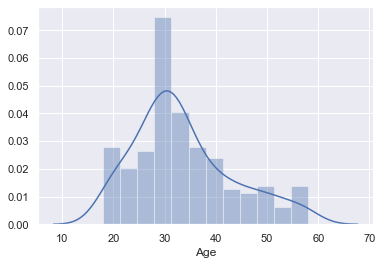

In [56]:
sns.distplot(leaver_df['Age'])

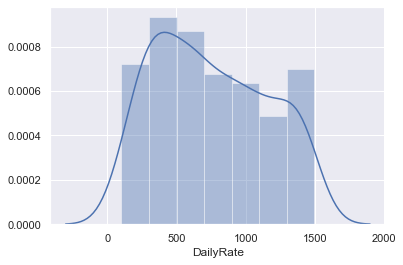

In [57]:
sns.distplot(leaver_df['DailyRate'])

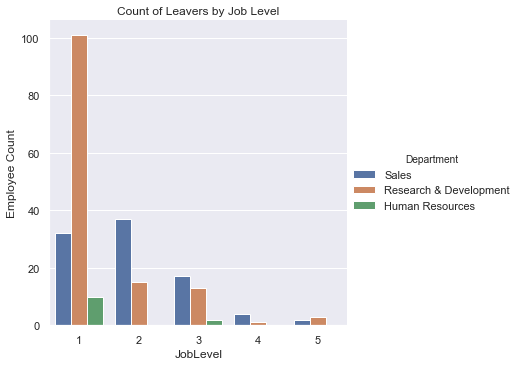

In [66]:
fig = sns.catplot(x='JobLevel', kind='count', hue='Department', data=leaver_df )
fig.set(xlabel='JobLevel', ylabel="Employee Count", title="Count of Leavers by Job Level");

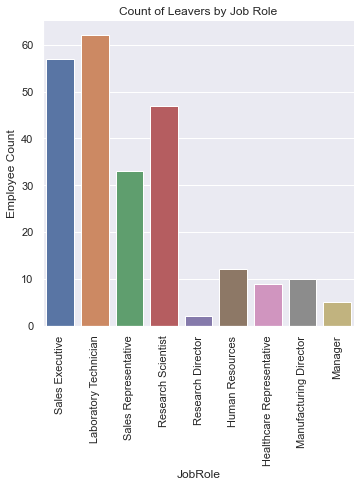

In [63]:
fig = sns.catplot(x='JobRole', kind='count', data=leaver_df )
fig.set(xlabel='JobRole', ylabel="Employee Count", title="Count of Leavers by Job Role")
fig.set_xticklabels(rotation=90);

In [68]:
leaver_df[leaver_df['Department'] == 'Research & Development'].describe(include='all')

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,133.000000,133,133,133.000000,133,133.000000,133.000000,133,133.0,133.000000,133.000000,133,133.000000,133.000000,133.000000,133,133.000000,133,133.000000,133.000000,133.000000,133,133,133.000000,133.000000,133.000000,133.0,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
unique,NaN,1,3,NaN,1,NaN,NaN,4,NaN,NaN,NaN,2,NaN,NaN,NaN,6,NaN,3,NaN,NaN,NaN,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Yes,Travel_Rarely,NaN,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,NaN,Male,NaN,NaN,NaN,Laboratory Technician,NaN,Single,NaN,NaN,NaN,Y,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,133,88,NaN,133,NaN,NaN,59,NaN,NaN,NaN,90,NaN,NaN,NaN,62,NaN,66,NaN,NaN,NaN,133,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,33.473684,NaN,NaN,754.548872,NaN,10.263158,2.827068,NaN,1.0,949.744361,2.473684,NaN,66.834586,2.556391,1.421053,NaN,2.458647,NaN,4108.075188,14145.345865,2.924812,NaN,NaN,15.308271,3.195489,2.518797,80.0,0.518797,8.082707,2.586466,2.578947,4.954887,2.706767,1.872180,2.849624
std,9.902233,NaN,NaN,405.924561,NaN,8.386402,1.026256,NaN,0.0,557.743053,1.190740,NaN,20.579182,0.711523,0.872219,NaN,1.118110,NaN,3393.026241,7164.570549,2.675999,NaN,NaN,4.013576,0.398076,1.165160,0.0,0.812791,7.332002,1.256063,0.863489,6.048872,3.192752,3.262304,3.090788
min,18.000000,NaN,NaN,103.000000,NaN,1.000000,1.000000,NaN,1.0,4.000000,1.000000,NaN,31.000000,1.000000,1.000000,NaN,1.000000,NaN,1009.000000,2396.000000,0.000000,NaN,NaN,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,NaN,NaN,381.000000,NaN,3.000000,2.000000,NaN,1.0,440.000000,1.000000,NaN,50.000000,2.000000,1.000000,NaN,1.000000,NaN,2362.000000,8269.000000,1.000000,NaN,NaN,12.000000,3.000000,1.000000,80.0,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,31.000000,NaN,NaN,699.000000,NaN,8.000000,3.000000,NaN,1.0,994.000000,3.000000,NaN,67.000000,3.000000,1.000000,NaN,3.000000,NaN,2759.000000,14180.000000,1.000000,NaN,NaN,14.000000,3.000000,3.000000,80.0,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,38.000000,NaN,NaN,1097.000000,NaN,16.000000,4.000000,NaN,1.0,1389.000000,4.000000,NaN,85.000000,3.000000,1.000000,NaN,3.000000,NaN,4213.000000,20366.000000,5.000000,NaN,NaN,18.000000,3.000000,4.000000,80.0,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000


In [ ]:
1/0

# Train Test Split

In [ ]:
target = hr_df['Attrition']
features = hr_df.drop(['Attrition'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=234)

Must retain the order of columns for usage later on.

In [ ]:
train_df = x_train.copy()
train_df.insert(0, 'Attrition', y_train)
train_df.reset_index(drop=True, inplace=True)
train_df

In [ ]:
# train_df = x_train.copy()
# train_df['Attrition'] = y_train
# train_df['Attrition']

In [ ]:
check_train_df = pd.merge(left=train_df, right=hr_df, on=['EmployeeNumber'])
check_train_df[(check_train_df['Attrition_x'] != check_train_df['Attrition_y'])]

In [ ]:
test_df = x_test.copy()
test_df.insert(0, 'Attrition', y_test)
test_df.reset_index(drop=True, inplace=True)
test_df

In [ ]:
check_test_df = pd.merge(left=test_df, right=hr_df, on=['EmployeeNumber'])
# check_test_df
check_test_df[(check_test_df['Attrition_x'] != check_test_df['Attrition_y'])]

# FOR LOOPS

In [7]:
nominal_categories = ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 
                      'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

In [ ]:
train_df[nominal_categories].columns

In [ ]:
hr_df[nominal_categories].columns

In [ ]:
ohe = OneHotEncoder(categories='auto', drop='first')
ohe.fit(train_df[nominal_categories])
train_arr = ohe.transform(train_df[nominal_categories]).toarray()
train_arr

In [ ]:
train_cols = ohe.get_feature_names()
train_cols_list = train_cols.tolist()
train_cols_list

In [ ]:
new_cols_list = []
for index, value in enumerate(train_cols_list):
    new_cols_list.append(nominal_categories[int(value[1])] + value[2:])
    continue
new_cols_list

In [ ]:
train_ohe_df = pd.DataFrame(train_arr, columns=new_cols_list)
train_ohe_df

In [ ]:
train_df = pd.merge(left=train_df, right=train_ohe_df, left_index=True, right_index=True)
train_df

Drop the original nominal category columns so that only the one-hot encoded columns remain

In [ ]:
train_df.drop(nominal_categories, axis=1, inplace=True)
train_df